## Setup

In [ ]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 706kB 8.4MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/Shareddrives/EE147

Mounted at /content/drive
/content/drive/Shareddrives/EE147


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

## Prepare the data

In [ ]:
import utils.dataprep as dp
# Package returned variables in 'raw' variable (create new variables for each value)
raw = lambda _: ()
(raw.X_train_valid, raw.y_train_valid, _), (raw.X_test, raw.y_test, _) = dp.load_data()

print('\n---- Splitting Data ----')
(raw.X_train, raw.y_train), (raw.X_valid, raw.y_valid) = \
    dp.split_data(raw.X_train_valid, raw.y_train_valid)

print('\n---- Augmenting Data ----')
prep = lambda _: ()
prep.X_train, prep.y_train = dp.data_prep(raw.X_train, raw.y_train, 2, 2)
print('X-train', prep.X_train.shape, 'with labels', prep.y_train.shape)
prep.X_valid, prep.y_valid = dp.data_prep(raw.X_valid, raw.y_valid, 2, 2)
print('X-valid', prep.X_valid.shape, 'with labels', prep.y_valid.shape)
prep.X_test,  prep.y_test  = dp.data_prep(raw.X_test,  raw.y_test,  2, 2)
print('X-test', prep.X_test.shape, 'with labels', prep.y_test.shape)

X_train = prep.X_train.reshape(*prep.X_train.shape, 1)
X_train = np.swapaxes(X_train, 1, 2)
y_train = prep.y_train

X_valid = prep.X_valid.reshape(*prep.X_valid.shape, 1)
X_valid = np.swapaxes(X_valid, 1, 2)
y_valid = prep.y_valid

X_test = prep.X_test.reshape(*prep.X_test.shape, 1)
X_test = np.swapaxes(X_test, 1, 2)
y_test = prep.y_test

print('\n---- Reshaping Data ----')
print ("X-train", X_train.shape, "with labels", y_train.shape)
print ("X-valid", X_valid.shape, "with labels", y_valid.shape)
print ("X-test", X_test.shape, "with labels", y_test.shape)

Loading data from /content/drive/Shareddrives/EE147/project_data/
Training/Valid data shape: (2115, 22, 1000)
Training/Valid target shape: (2115,)
Person train/valid shape: (2115,)
Test data shape: (443, 22, 1000)
Test target shape: (443,)
Person test shape: (443,)

---- Splitting Data ----
Training Data: (1692, 22, 1000) with labels (1692,)
Validate Data: (423, 22, 1000) with labels (423,)

---- Augmenting Data ----
X-train (6768, 22, 250) with labels (6768,)
X-valid (1692, 22, 250) with labels (1692,)
X-test (1772, 22, 250) with labels (1772,)

---- Reshaping Data ----
X-train (6768, 250, 22, 1) with labels (6768,)
X-valid (1692, 250, 22, 1) with labels (1692,)
X-test (1772, 250, 22, 1) with labels (1772,)


## Hyperparameters

In [ ]:
learning_rate = 1e-3
weight_decay = 1e-4
batch_size = 256
num_epochs = 500
image_size = 250  # We'll resize input images to this size
patch_size = 10  # Size of the patches to be extract from the input images
patch_width = 22
num_patches = image_size * 22 // (patch_size * patch_width)
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [128, 64]  # Size of the dense layers of the final classifier

## MLP

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Patch creation layer

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, patch_width, 1],
            strides=[1, self.patch_size, patch_width, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Display patches for a sample image

(1, 250, 22, 1)


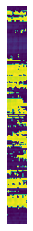

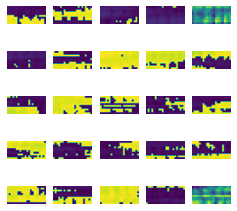

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.reshape((250, 22)).astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, patch_width)
)
patches = Patches(patch_size)(resized_image)
# print(f"Image size: {image_size} X {image_size}")
# print(f"Patch size: {patch_size} X {patch_size}")
# print(f"Patches per image: {patches.shape[1]}")
# print(f"Elements per patch: {patches.shape[-1]}")
print(resized_image.shape)

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_width, 1))
    plt.imshow(patch_img.numpy().reshape((patch_size, patch_width)).astype("uint8"))
    plt.axis("off")

## Patch encoding layer

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## Build the ViT model

In [ ]:
def create_vit_classifier():
    input_shape = (250, 22, 1)
    num_classes = 4
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    # augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.5
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.5)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes, activation='softmax')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

## Compile the model

In [ ]:
def run_experiment(model):
    # optimizer = tfa.optimizers.AdamW(
    #     learning_rate=learning_rate, weight_decay=weight_decay
    # )

    optimizer = tfa.optimizers.SGDW(
        learning_rate=learning_rate, momentum=0.97, weight_decay=weight_decay
        )
    
    # def scheduler(epoch, lr):
    #     if epoch % 10 != 0:
    #         return lr
    #     else:
    #         return lr * .5
    # lr_decay = keras.callbacks.LearningRateScheduler(scheduler)
    lr_decay = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=15, verbose=1)

    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=50)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(),
        # loss = keras.losses.CategoricalCrossentropy()
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            # keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
        ],
    )

    checkpoint_filepath = "/content/drive/Shareddrives/EE147/vit_checkpoint/vit_checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(X_valid, y_valid),
        callbacks=[checkpoint_callback, lr_decay, early_stopping],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(X_test, y_test)
    # _, accuracy, top_2_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # print(f"Test top 2 accuracy: {round(top_2_accuracy * 100, 2)}%")

    return history

# history = run_experiment(create_vit_classifier())
model = create_vit_classifier()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 250, 22, 1)] 0                                            
__________________________________________________________________________________________________
patches_3 (Patches)             (None, None, 220)    0           input_3[0][0]                    
__________________________________________________________________________________________________
patch_encoder_2 (PatchEncoder)  (None, 25, 64)       15744       patches_3[0][0]                  
__________________________________________________________________________________________________
layer_normalization_34 (LayerNo (None, 25, 64)       128         patch_encoder_2[0][0]            
____________________________________________________________________________________________

In [ ]:
optimizer = tfa.optimizers.SGDW(
    learning_rate=learning_rate, momentum=0.95, weight_decay=weight_decay
    )

# def scheduler(epoch, lr):
#     if epoch % 10 != 0:
#         return lr
#     else:
#         return lr * .5
# lr_decay = keras.callbacks.LearningRateScheduler(scheduler)
lr_decay = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=15, verbose=1)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=50)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # loss = keras.losses.CategoricalCrossentropy()
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        # keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
    ],
)



In [ ]:
def run_experiment(model):
    # optimizer = tfa.optimizers.AdamW(
    #     learning_rate=learning_rate, weight_decay=weight_decay
    # )

    optimizer = tfa.optimizers.SGDW(
        learning_rate=learning_rate, momentum=0.95, weight_decay=weight_decay
    )
    
    lr_decay = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=15, verbose=1)

    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=50)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(),
        # loss = keras.losses.CategoricalCrossentropy()
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            # keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
        ],
    )

    checkpoint_filepath = "/content/drive/Shareddrives/EE147/vit_checkpoint/vit"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(X_valid, y_valid),
        callbacks=[checkpoint_callback, lr_decay, early_stopping],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(X_test, y_test)
    # _, accuracy, top_2_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # print(f"Test top 2 accuracy: {round(top_2_accuracy * 100, 2)}%")

    return history

history = run_experiment(create_vit_classifier())

Epoch 1/500
27/27 [==============================] - 11s 81ms/step - loss: 2.7716 - accuracy: 0.2509 - val_loss: 1.4463 - val_accuracy: 0.2612
Epoch 2/500
27/27 [==============================] - 1s 39ms/step - loss: 1.9659 - accuracy: 0.2711 - val_loss: 1.3806 - val_accuracy: 0.3121
Epoch 3/500
27/27 [==============================] - 1s 39ms/step - loss: 1.6214 - accuracy: 0.2842 - val_loss: 1.3681 - val_accuracy: 0.3103
Epoch 4/500
27/27 [==============================] - 1s 39ms/step - loss: 1.5002 - accuracy: 0.2916 - val_loss: 1.3637 - val_accuracy: 0.3180
Epoch 5/500
27/27 [==============================] - 1s 39ms/step - loss: 1.4643 - accuracy: 0.2921 - val_loss: 1.3621 - val_accuracy: 0.3221
Epoch 6/500
27/27 [==============================] - 1s 41ms/step - loss: 1.4397 - accuracy: 0.2833 - val_loss: 1.3617 - val_accuracy: 0.3262
Epoch 7/500
27/27 [==============================] - 1s 39ms/step - loss: 1.4067 - accuracy: 0.3007 - val_loss: 1.3598 - val_accuracy: 0.3310
Epoch

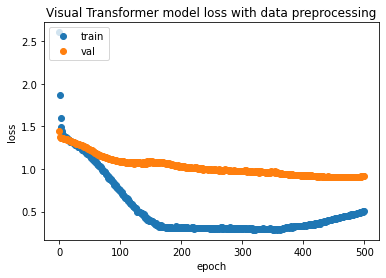

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'],'o')
plt.plot(history.history['val_loss'],'o')
plt.title('Visual Transformer model loss with data preprocessing')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def run_experiment(model):
    # optimizer = tfa.optimizers.AdamW(
    #     learning_rate=learning_rate, weight_decay=weight_decay
    # )

    optimizer = tfa.optimizers.SGDW(
        learning_rate=learning_rate, momentum=0.95, weight_decay=weight_decay
        )
    
    # def scheduler(epoch, lr):
    #     if epoch % 10 != 0:
    #         return lr
    #     else:
    #         return lr * .5
    # lr_decay = keras.callbacks.LearningRateScheduler(scheduler)
    lr_decay = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=15, verbose=1)

    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=50)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(),
        # loss = keras.losses.CategoricalCrossentropy()
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            # keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
        ],
    )

    checkpoint_filepath = "/content/drive/Shareddrives/EE147/vit_checkpoint/vit_checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=1000,
        validation_data=(X_valid, y_valid),
        callbacks=[checkpoint_callback, lr_decay, early_stopping],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(X_test, y_test)
    # _, accuracy, top_2_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # print(f"Test top 2 accuracy: {round(top_2_accuracy * 100, 2)}%")

    return history

history = run_experiment(create_vit_classifier())

Epoch 1/1000
27/27 [==============================] - 11s 79ms/step - loss: 2.9108 - accuracy: 0.2579 - val_loss: 1.4206 - val_accuracy: 0.2660
Epoch 2/1000
27/27 [==============================] - 1s 39ms/step - loss: 2.0439 - accuracy: 0.2648 - val_loss: 1.3718 - val_accuracy: 0.2796
Epoch 3/1000
27/27 [==============================] - 1s 39ms/step - loss: 1.6398 - accuracy: 0.2778 - val_loss: 1.3665 - val_accuracy: 0.2914
Epoch 4/1000
27/27 [==============================] - 1s 39ms/step - loss: 1.5117 - accuracy: 0.2815 - val_loss: 1.3661 - val_accuracy: 0.3002
Epoch 5/1000
27/27 [==============================] - 1s 39ms/step - loss: 1.4650 - accuracy: 0.2798 - val_loss: 1.3657 - val_accuracy: 0.2914
Epoch 6/1000
27/27 [==============================] - 1s 39ms/step - loss: 1.4400 - accuracy: 0.2884 - val_loss: 1.3647 - val_accuracy: 0.2985
Epoch 7/1000
27/27 [==============================] - 1s 39ms/step - loss: 1.4160 - accuracy: 0.2917 - val_loss: 1.3643 - val_accuracy: 0.297